In [11]:
import tools.file as tf
import drawwithplt as Dplt
from drawwithplt import plt
Dplt.plt.style.use(["science", "grid"])

import numpy as np
import pandas as pd
import copy
import pickle as pkl
from sklearn.neighbors import NearestNeighbors
import numpy as np
import math
import time
import requests

In [12]:
# 读取CSV文件
df = pd.read_csv('Data/TrafficNet/地名地址信息;交通地名;路口名.csv')

# 显示前几行数据以检查
df[56:58]

c:\Users\LIFTES-NONET\Anaconda3\envs\py3.7\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,pcode,type,gridcode,typecode,citycode,adname,id,address,adcode,pname,...,name,location,longitude_gcj02,latitude_gcj02,longitude_wgs84,latitude_wgs84,typecode_single,大类,中类,小类
56,110000,地名地址信息;交通地名;路口名,5915347902,190302,10,房山区,B0FFHPLCIS,房山区,110111,北京市,...,七孤路与涞宝路交叉口,"115.623374,39.643195",115.623374,39.643195,115.617340,39.642192,190302,地名地址信息,交通地名,路口名
57,110000,地名地址信息;交通地名;路口名,5915356011,190302,10,房山区,B0FFHPGTJA,房山区,110111,北京市,...,六石路与涞宝路交叉口,"115.632419,39.638776",115.632419,39.638776,115.626375,39.637763,190302,地名地址信息,交通地名,路口名


In [13]:
def Filter_by_coordinates(df, long_min=None, long_max=None, lat_min=None, lat_max=None):
    """
    筛选在指定经纬度范围内的数据。

    参数:
        df (pd.DataFrame): 输入的数据，应包含'longitude'和'latitude'两列。
        long_min (float, optional): 最小经度值。默认为None。
        long_max (float, optional): 最大经度值。默认为None。
        lat_min (float, optional): 最小纬度值。默认为None。
        lat_max (float, optional): 最大纬度值。默认为None。

    返回:
        pd.DataFrame: 筛选后的数据。
    """
    
    if long_min is not None:
        df = df[df['longitude_gcj02'] >= long_min]
    if long_max is not None:
        df = df[df['longitude_gcj02'] <= long_max]
    if lat_min is not None:
        df = df[df['latitude_gcj02'] >= lat_min]
    if lat_max is not None:
        df = df[df['latitude_gcj02'] <= lat_max]
    
    return df


In [14]:
def Plot_points_within_bounds(df, long_min=None, long_max=None, lat_min=None, lat_max=None):
    """
    根据指定的经纬度范围，绘制图中的点。如果没有指定范围，就使用数据的最小和最大值。
    
    参数:
    - df: DataFrame，包含经纬度信息的数据
    - long_min, long_max: 经度的最小和最大值
    - lat_min, lat_max: 纬度的最小和最大值
    """
    # 如果没有指定范围，则使用数据的最小和最大值
    if long_min is None:
        long_min = df['longitude_gcj02'].min()
    if long_max is None:
        long_max = df['longitude_gcj02'].max()
    if lat_min is None:
        lat_min = df['latitude_gcj02'].min()
    if lat_max is None:
        lat_max = df['latitude_gcj02'].max()

    # 根据指定的经纬度范围过滤数据
    df_filtered = df[(df['longitude_gcj02'] >= long_min) & 
                     (df['longitude_gcj02'] <= long_max) & 
                     (df['latitude_gcj02'] >= lat_min) & 
                     (df['latitude_gcj02'] <= lat_max)]
    
    # 添加额外的空间，确保点不会紧贴图像边缘
    padding_long = (long_max - long_min) * 0.05
    padding_lat = (lat_max - lat_min) * 0.05
    
    # 绘制图形
    plt.figure(figsize=(5, 5))
    plt.scatter(df_filtered['longitude_gcj02'], df_filtered['latitude_gcj02'], s=5, color='blue')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.xlim(long_min - padding_long, long_max + padding_long)  # 设置x轴范围
    plt.ylim(lat_min - padding_lat, lat_max + padding_lat)   # 设置y轴范围


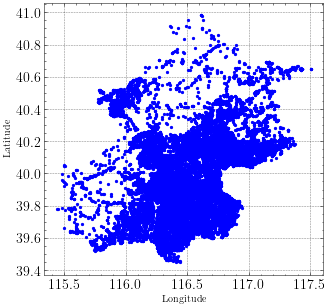

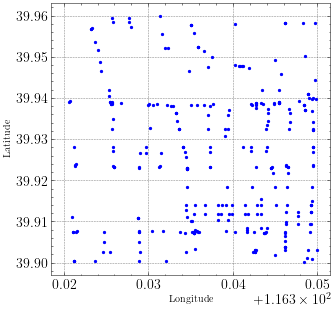

In [15]:
Plot_points_within_bounds(df)
Plot_points_within_bounds(df,116.32,116.35,39.90,39.96)

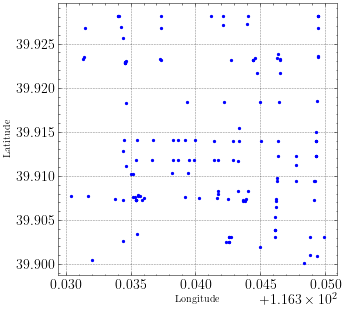

In [16]:
tmpdf = Filter_by_coordinates(df,116.33,116.35,39.90,39.93)
Plot_points_within_bounds(tmpdf)

In [17]:
def Haversine_distance(origin, destination):
    """
    使用Haversine公式计算两点间的距离。
    返回的距离单位为米。
    """
    # 地球半径，单位为米
    R = 6371000
    lat1, lon1 = math.radians(origin[1]), math.radians(origin[0])
    lat2, lon2 = math.radians(destination[1]), math.radians(destination[0])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = (math.sin(dlat / 2) ** 2 +
         math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2)
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    return R * c

def Is_adjacent(origin, destination, threshold=1.1, sleeptime=2):
    """
    使用API导航来判断两个路口是否相邻。
    如果导航路径等于或略大于两点间的直线距离，则判断两者间有道路连接。
    """
    time.sleep(sleeptime)
    # 这里使用高德API作为示例
    api_url = "https://restapi.amap.com/v3/direction/walking?origin={},{}&destination={},{}&key=feac9a525ffa71a7f5d2a035bf2e0b1c"
    
    retries = 0
    max_retries = 10
    while retries < max_retries:
        try:
            response = requests.get(api_url.format(origin[0], origin[1], destination[0], destination[1]))
            data = response.json()

            # 计算导航距离
            nav_distance = data['route']['paths'][0]['distance']

            # 计算两点间的直线距离
            straight_distance = Haversine_distance(origin, destination)

            print(nav_distance, straight_distance)
            return float(nav_distance) <= straight_distance * threshold

        except requests.RequestException as e:  # 包括超时、连接错误等
            if retries < max_retries - 1:  # 判断是否达到重试次数
                print(f"Error occurred: {e}. Retrying in 5 seconds...")
                time.sleep(5)
                retries += 1
            else:
                print(f"Max retries reached. Exiting...")
                return False

    return False

def Get_direction(origin, destination):
    """
    通过经纬度计算两点间连线的tan值，来判断道路是东西连接还是南北连接。
    """
    delta_x = destination[0] - origin[0]
    delta_y = destination[1] - origin[1]
    
    # 计算tan值
    tan_value = abs(delta_y / delta_x)
    
    # 判断方向
    if tan_value > 1:
        return "南北方向"
    else:
        return "东西方向"

def Merge_close_points(df, threshold=30):
    """
    归并距离小于给定阈值的点。
    返回一个新的DataFrame，其中距离小于阈值的点已被归并。
    """
    used_indices = set()
    new_rows = []
    
    for i, row in df.iterrows():
        if i in used_indices:
            continue

        close_points = []
        for j, compare_row in df.iterrows():
            if j in used_indices:
                continue
            distance = Haversine_distance((row['longitude_gcj02'], row['latitude_gcj02']), 
                                          (compare_row['longitude_gcj02'], compare_row['latitude_gcj02']))
            if distance <= threshold:
                close_points.append((compare_row['longitude_gcj02'], compare_row['latitude_gcj02']))
                used_indices.add(j)
                
        # 计算归并点的均值坐标
        avg_longitude = sum(p[0] for p in close_points) / len(close_points)
        avg_latitude = sum(p[1] for p in close_points) / len(close_points)
        
        # 找到与均值最接近的点，并使用该点的所有列信息
        closest_point = min(close_points, key=lambda p: Haversine_distance(p, (avg_longitude, avg_latitude)))
        closest_row = df[(df['longitude_gcj02'] == closest_point[0]) & 
                         (df['latitude_gcj02'] == closest_point[1])].iloc[0]
        
        new_row = closest_row.to_dict()
        new_row['longitude_gcj02'] = avg_longitude
        new_row['latitude_gcj02'] = avg_latitude
        new_rows.append(new_row)

    return pd.DataFrame(new_rows)


# 使用示例
# origin = (116.397570, 39.908821)
# destination = (116.398570, 39.908821)
# if Is_adjacent(origin, destination):
#     print("两点相邻")
#     print("方向:", Get_direction(origin, destination))


In [18]:
def Assign_ids_to_intersections(df):
    """
    对每个路口分配一个ID。
    """
    df = df.reset_index(drop=True)
    df['id'] = df.index
    return df

def AngleBetween(p1, p2):
    """
    计算点p1和p2之间的角度。
    """
    deltaY = p2[1] - p1[1]
    deltaX = p2[0] - p1[0]
    angle = math.atan2(deltaY, deltaX)
    return math.degrees(angle)

def FindNeighbors(df, n_neighbors=9):  # 我们现在需要查找至少9个邻居（包括点自己）
    coords = df[['latitude_gcj02', 'longitude_gcj02']].values
    ids = df['id'].values
    
    directions = {
        'north': (-90, -45),
        'east': (-45, 45),
        'south': (45, 135),
        'west': (135, 180),
    }
    
    for i, coord in enumerate(coords):
        distances, indices = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(coords).kneighbors([coord])
        
        for direction, (angle_min, angle_max) in directions.items():
            nearest_found = False
            for idx in indices[0][1:]:  # 跳过点自己
                target_coord = coords[idx]
                angle = AngleBetween(coord, target_coord)
                
                if angle_min <= angle < angle_max:
                    if not nearest_found:
                        df.at[i, f'nearest_{direction}'] = ids[idx]
                        nearest_found = True
                    else:
                        df.at[i, f'second_nearest_{direction}'] = ids[idx]
                        break
    
    return df

def GenerateAdjacentDict(df, sleeptime = 5):
    adjacent_dict = {}
    
    for index, row in df.iterrows():
        for direction in ["east", "west", "north", "south"]:
            origin_id = row["id"]
            
            # 检查df中是否存在最近邻点或第二近邻点
            if pd.notnull(row[f"nearest_{direction}"]):
                nearest_id = int(row[f"nearest_{direction}"])
            else:
                continue
                
            if pd.notnull(row[f"second_nearest_{direction}"]):
                second_nearest_id = int(row[f"second_nearest_{direction}"])
            else:
                second_nearest_id = None

            origin_coord = (df[df["id"] == origin_id]["longitude_gcj02"].values[0], 
                            df[df["id"] == origin_id]["latitude_gcj02"].values[0])
            
            # 获取最近邻点的坐标
            nearest_coord = (df[df["id"] == nearest_id]["longitude_gcj02"].values[0], 
                             df[df["id"] == nearest_id]["latitude_gcj02"].values[0])
            
            # 检查最近邻点是否有连接
            if Is_adjacent(origin_coord, nearest_coord, threshold=1.1, sleeptime = sleeptime):
                adjacent_dict[(origin_id, nearest_id)] = direction
            elif second_nearest_id:  # 如果最近邻点没有连接，检查第二近邻点
                second_nearest_coord = (df[df["id"] == second_nearest_id]["longitude_gcj02"].values[0], 
                                        df[df["id"] == second_nearest_id]["latitude_gcj02"].values[0])
                if Is_adjacent(origin_coord, second_nearest_coord, threshold=1.1, sleeptime = sleeptime):
                    adjacent_dict[(origin_id, second_nearest_id)] = direction

    return adjacent_dict



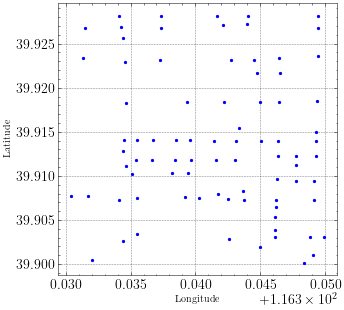

In [21]:
tmpdf = Merge_close_points(tmpdf, threshold=80)
Plot_points_within_bounds(tmpdf)

In [22]:
tmpdf = Assign_ids_to_intersections(tmpdf)
tmpdf = FindNeighbors(tmpdf)
adj_dict = GenerateAdjacentDict(tmpdf)

1011 772.2985349631189
1366 801.5762380390747
425 314.32374670749607
546 432.1671941334097
145 110.25031528016822
399 328.9991160987213
351 351.9117053059012
253 235.31910934480086
382 344.04656361360657
465 405.35700767562906
684 452.40145020373546
778 555.5749614011006
840 604.3908111208073
718 579.6122479227541
229 205.1314552261021
347 323.2966356210553
587 512.1572404276828
681 538.2969743802979
122 119.27257240177872
995 665.9686027737272
959 655.3846722653964
118 117.30889786495322
449 334.18186575306106
553 431.4056445873424
465 451.4272989106362
229 205.1314552261021
348 319.9040190154945
146 124.000980153534
559 453.7761298479201
465 451.4272989106362
834 649.6992048037971
987 616.0220441283892
331 306.54477335984774
347 323.2966356210553
336 314.24153068619563
191 186.34319270557356
112 113.53787450474444
306 104.21735905334465
411 191.73120854468954
124 137.27307917665962
192 186.34319270557356
160 137.38197440742007
265 219.90547651987993
112 113.53787450474444
331 306.544

In [23]:
tf.Save_data(adj_dict, "Data/TrafficNet/adj_dict.pkl")

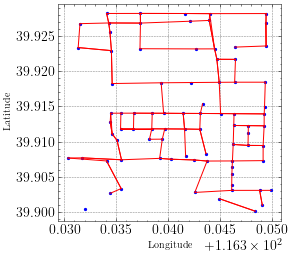

In [24]:
def Plot_points_and_lines_within_bounds(df, adj_dict, long_min=None, long_max=None, lat_min=None, lat_max=None):
    """
    根据指定的经纬度范围，绘制图中的点和连接的线。如果没有指定范围，就使用数据的最小和最大值。
    
    参数:
    - df: DataFrame，包含经纬度信息的数据
    - adj_dict: 字典，包含相邻路口的id和方向信息
    - long_min, long_max: 经度的最小和最大值
    - lat_min, lat_max: 纬度的最小和最大值
    """
    # 如果没有指定范围，则使用数据的最小和最大值
    if long_min is None:
        long_min = df['longitude_gcj02'].min()
    if long_max is None:
        long_max = df['longitude_gcj02'].max()
    if lat_min is None:
        lat_min = df['latitude_gcj02'].min()
    if lat_max is None:
        lat_max = df['latitude_gcj02'].max()

    # 根据指定的经纬度范围过滤数据
    df_filtered = df[(df['longitude_gcj02'] >= long_min) & 
                     (df['longitude_gcj02'] <= long_max) & 
                     (df['latitude_gcj02'] >= lat_min) & 
                     (df['latitude_gcj02'] <= lat_max)]
    
    # 添加额外的空间，确保点不会紧贴图像边缘
    padding_long = (long_max - long_min) * 0.05
    padding_lat = (lat_max - lat_min) * 0.05
    
    # 绘制图形
    plt.figure(figsize=(4, 4))
    plt.scatter(df_filtered['longitude_gcj02'], df_filtered['latitude_gcj02'], s=5, color='blue')
    
    # 绘制两点之间的连线
    for (origin_id, destination_id), direction in adj_dict.items():
        # 获取起点和终点的坐标
        origin_coords = df[df["id"] == origin_id][['longitude_gcj02', 'latitude_gcj02']].values[0]
        dest_coords = df[df["id"] == destination_id][['longitude_gcj02', 'latitude_gcj02']].values[0]
        
        # 画线
        plt.plot([origin_coords[0], dest_coords[0]], [origin_coords[1], dest_coords[1]], color='red')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.xlim(long_min - padding_long, long_max + padding_long)  # 设置x轴范围
    plt.ylim(lat_min - padding_lat, lat_max + padding_lat)   # 设置y轴范围
    plt.show()

Plot_points_and_lines_within_bounds(tmpdf, adj_dict)